# 추가분석 : Mobile 고객 이탈 분석

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 데이터분석을 의뢰하였습니다.
* 고객 이탈여부(CHURN)에 영향을 주는 요인을 찾아 봅시다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [4]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
mobile = pd.read_csv(data_path)
mobile.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
mobile

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,47711,183,17,730589.0,192,5,unsat,considering,0
1,0,74132,191,43,535092.0,349,2,unsat,no,1
2,1,150419,0,14,204004.0,682,6,unsat,considering,0
3,0,159567,0,58,281969.0,634,1,very_unsat,never_thought,0
4,1,23392,0,0,216707.0,233,15,unsat,no,1
...,...,...,...,...,...,...,...,...,...,...
17995,0,31079,200,40,NaN,181,11,unsat,actively_looking_into_it,0
17996,0,137194,63,0,NaN,787,11,very_unsat,no,1
17997,0,82931,0,77,NaN,232,2,very_unsat,never_thought,0
17998,0,124391,0,19,NaN,862,2,unsat,no,0


|변수 명|내용|구분|
|----|----|----|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [3]:
mobile.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                         215
HANDSET_PRICE                   0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
CONSIDERING_CHANGE_OF_PLAN      0
CHURN                           0
dtype: int64

----

## 1.이변량 분석
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

In [26]:
target = 'CHURN'

### (1) 범주형 Feature --> CHURN
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다.

In [6]:
# 전체 이탈율
total_mean = mobile[target].mean()
print(total_mean)

0.49272222222222223


#### 1) COLLEGE --> CHURN

In [33]:
feature = 'COLLEGE' # 대학졸업 여부(1,0) - 범주

In [36]:
def table(feature, target, data):
    table = pd.crosstab(data[feature], data[target])
    return table

In [38]:
def mosaic_plot(plot, featurn, target):
    mosaic(plot, [feature, target])
    plt.axhline(1- plot[target].mean(), color='r')

In [40]:
def kai_gon(table):
    statistic, p_value, dof, dd = spst.chi2_contingency(table)
    print(f'상관계수: {statistic}, p_value: {p_value}, 자유도: {dof}')

① 교차표(pd.crosstab())

In [42]:
cross_table = table(feature, target, mobile)
cross_table

CHURN,0,1
COLLEGE,,
0,4616,4335
1,4515,4534


② 시각화( Stacked Bar, Mosaic)

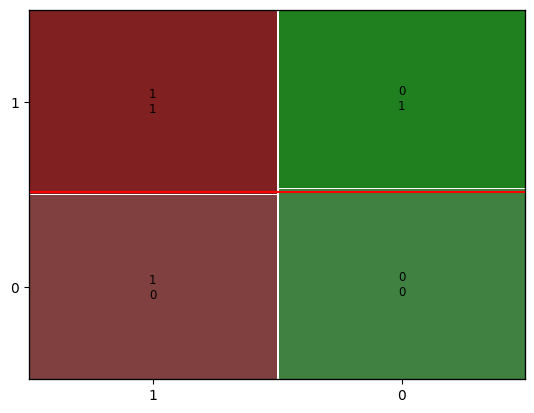

In [39]:
mosaic_plot(mobile, feature, target)

③ 가설검정(카이제곱검정)

In [43]:
kai_gon(cross_table)

상관계수: 4.982102934693502, p_value: 0.02561083347822053, 자유도: 1


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

> * 차트를 통해서는 대학졸업여부와 이탈여부는 관련이 없어 보임.
* 그러나 카이제곱검정으로는 pvalue가 0.02로 유의수준 0.05보다 작게 나옴
* 결론 : 약한 관계

#### 2) REPORTED_SATISFACTION  --> CHURN

In [47]:
feature = 'REPORTED_SATISFACTION' # 만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주

① 교차표(pd.crosstab())

In [49]:
cross_table = table(feature, target, mobile)
cross_table

CHURN,0,1
REPORTED_SATISFACTION,,
avg,952,854
sat,492,440
unsat,1792,1798
very_sat,2334,2228
very_unsat,3543,3529


② 시각화( Stacked Bar, Mosaic)

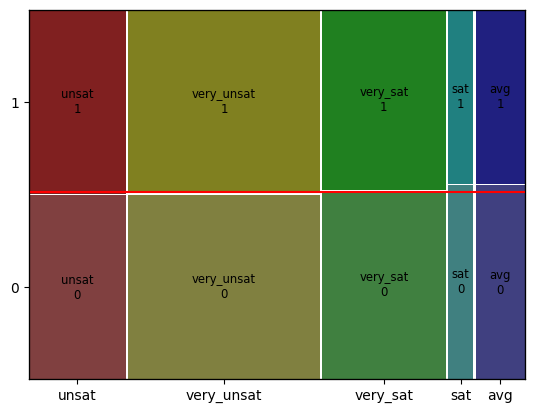

In [50]:
mosaic_plot(mobile, feature, target)

③ 가설검정(카이제곱검정)

In [51]:
kai_gon(cross_table)

상관계수: 6.841100957205645, p_value: 0.14452738878905058, 자유도: 4


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

In [53]:
# 차트 통해 만족도는 이탈 여부는 관련 없어보임
# 카이제곱 검정의 p_value도 0.05보다 큼
# 약한 관계

#### 3) CONSIDERING_CHANGE_OF_PLAN --> CHURN

In [54]:
feature = 'CONSIDERING_CHANGE_OF_PLAN' # 변경 계획 설문('never_thought', 'no', 'perhaps', 'considering', 'actively_looking_into_it') - 범주

① 교차표(pd.crosstab())

In [57]:
cross_table = table(feature, target, mobile)
cross_table

CHURN,0,1
CONSIDERING_CHANGE_OF_PLAN,,
actively_looking_into_it,2278,2175
considering,3648,3493
never_thought,926,878
no,1823,1821
perhaps,456,502


② 시각화( Stacked Bar, Mosaic)

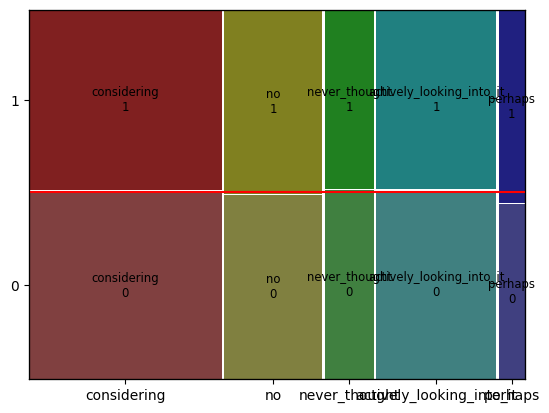

In [59]:
mosaic_plot(mobile, feature, target)

시각화를 통해 파악한 내용을 적어 봅시다.

③ 가설검정(카이제곱검정)

In [60]:
kai_gon(cross_table)

상관계수: 5.421434419620688, p_value: 0.24672225866799702, 자유도: 4


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

In [ ]:
# 차

### (2) 숫자형 Feature --> CHURN

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) INCOME --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 2) OVERAGE --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 3) LEFTOVER --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 4) HOUSE --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 5) HANDSET_PRICE --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 6) AVERAGE_CALL_DURATION --> CHURN


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

## 2.관계 정리

### 1) 강한관계의 변수

### 2) 약한관계의 변수

### 3) 관계 없음

### 4) 추가 분석